# Package install & Import

In [1]:
!pip install scikit-learn==0.23.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 6.8 MB 5.0 MB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.2
    Uninstalling scikit-learn-1.0.2:
      Successfully uninstalled scikit-learn-1.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.4 requires scikit-learn>=1.0.0, but you have scikit-learn 0.23.2 which is incompatible.
imbalanced-learn 0.8.1 requires scikit-learn>=0.24, but you have scikit-learn 0.23.2 which is incompatible.


In [2]:
import sklearn
sklearn.__version__

'0.23.2'

In [ ]:
!pip install pycaret

*설치 버전 적용을 위해 런타임 다시 시작 후 코드 실행

In [4]:
from pycaret.utils import enable_colab
enable_colab()

Colab mode enabled.


In [5]:
!pip install markupsafe==2.0.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 2.1.1
    Uninstalling MarkupSafe-2.1.1:
      Successfully uninstalled MarkupSafe-2.1.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pandas-profiling 3.2.0 requires markupsafe~=2.1.1, but you have markupsafe 2.0.1 which is incompatible.


In [6]:
!pip install pymysql

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 43 kB 1.4 MB/s 


In [10]:
import pymysql
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer
from pycaret.classification import *
from pycaret.utils import check_metric
import matplotlib.pyplot as plt

# Load Data

In [87]:
# DB 연결
endpoint = 'dao.c51deksujiip.ap-northeast-2.rds.amazonaws.com'
schema_name = 'storage'
db_connection_str = 'mysql+pymysql://admin:ekfkawnl@{}/{}'.format(endpoint, schema_name )
try :
    db_connection = create_engine(db_connection_str)
    conn = db_connection.connect()
except :
    print('fail to connect db')

def load_data_from_rds(tabel_name):
  sql = "SELECT * FROM {}".format(tabel_name)
  df = pd.read_sql(sql, db_connection)
  return df

In [88]:
# maindata
df = load_data_from_rds('MainData')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 497 entries, 0 to 496
Data columns (total 27 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   번호                497 non-null    int64  
 1   위도                497 non-null    float64
 2   경도                497 non-null    float64
 3   폭                 318 non-null    float64
 4   연장                318 non-null    float64
 5   높이                43 non-null     float64
 6   개방도               43 non-null     float64
 7   차선_수              497 non-null    int64  
 8   생태통로타입            497 non-null    int64  
 9   등산객이용빈도           497 non-null    int64  
 10  생태통로효율성           497 non-null    int64  
 11  등산로까지 최단거리(km)    497 non-null    float64
 12  식생                497 non-null    int64  
 13  경사도               497 non-null    int64  
 14  지형기호(2.3km)       497 non-null    object 
 15  주변 동물종 개수         259 non-null    float64
 16  주변동물 출현빈도         259 non-null    float64
 1

# Preprocessing

## Translation columns name Korean to English

In [89]:
# rename columns
rename_col = {'번호' : 'num', 
              '위도' : 'latitude',
              '경도' : 'longitude',
              '생태통로타입' : 'type',
              '등산객이용빈도' : 'frequency_use_hikers',
              '생태통로효율성' : 'efficiency',
              '이용확인종_수' : 'num_use_species',
              '폭' : 'width',
              '연장' : 'length',
              '높이' : 'height',
              '개방도' : 'openness',
              '경사도' : 'soilslope',
              '주변 로드킬 빈도' : 'frequency_roadkill',
              '산책로까지의 최단 거리(km)' : 'dist_walkway',
              '농가까지의 거리(km)' : 'dist_farm',
              '최고제한속도(km/h)' : 'speed_limit',
              '주변 동물종 개수' : 'num_near_species',
              '주변동물 출현빈도' : 'frequency_appearance_animals',
              '지형기호(2.3km)' : 'topography',
              '하천거리(km)' : 'dist_river',
              '식생' : 'vegetation', 
              '등산로까지 최단거리(km)' : 'dist_hikingtrails',
              '유도울타리_위도_2.3km' : 'fence_latitude',
              '유도울타리_경도_2.3km' : 'fence_longitude',
              '유도울타리_연장_m' : 'fence_length',
              '유도울타리_높이_m' : 'fence_height',
              '교통량' : 'traffic_volume',
              '환경영향평가점수' : 'environmental_score', ## 국토환경성평가. 환경영향평가x
              '건물까지거리(km)' : 'dist_buildings',
              '차선_수' : 'num_lane'}

df.rename(columns=rename_col, inplace=True)

## Labeling

### efficiency : 0(낮음)/1(일정 수준 이상)

In [90]:
df['efficiency'] = [1 if x==2 else x for x in df['efficiency']]

## Type Split

In [91]:
df_overpass = df[df['type'] == 0]
df_tunnel = df[df['type'] != 0]

# drop unnecessary columns from overpass df
df_overpass.drop(['height', 'openness'], axis=1, inplace=True)

In [92]:
# reset index
df_overpass.reset_index(drop = True,inplace= True)
df_tunnel.reset_index(drop = True,inplace= True)

## Drop unnecessary columns

In [93]:
# drop columns
drop_col = ['num', 'latitude', 'longitude', 'type', 'frequency_roadkill']

df_overpass = df_overpass.drop(drop_col, axis=1)
df_tunnel = df_tunnel.drop(drop_col, axis=1)

## Outliers

### Boxplot

In [94]:
# categorical & numerical columns
categorical_col = ['frequency_use_hikers','soilslope','topography', 'vegetation', 'environmental_score', 'efficiency']
numerical_over = list(df_overpass.drop(categorical_col, axis=1).columns)
numerical_tun = list(df_tunnel.drop(categorical_col, axis=1).columns)

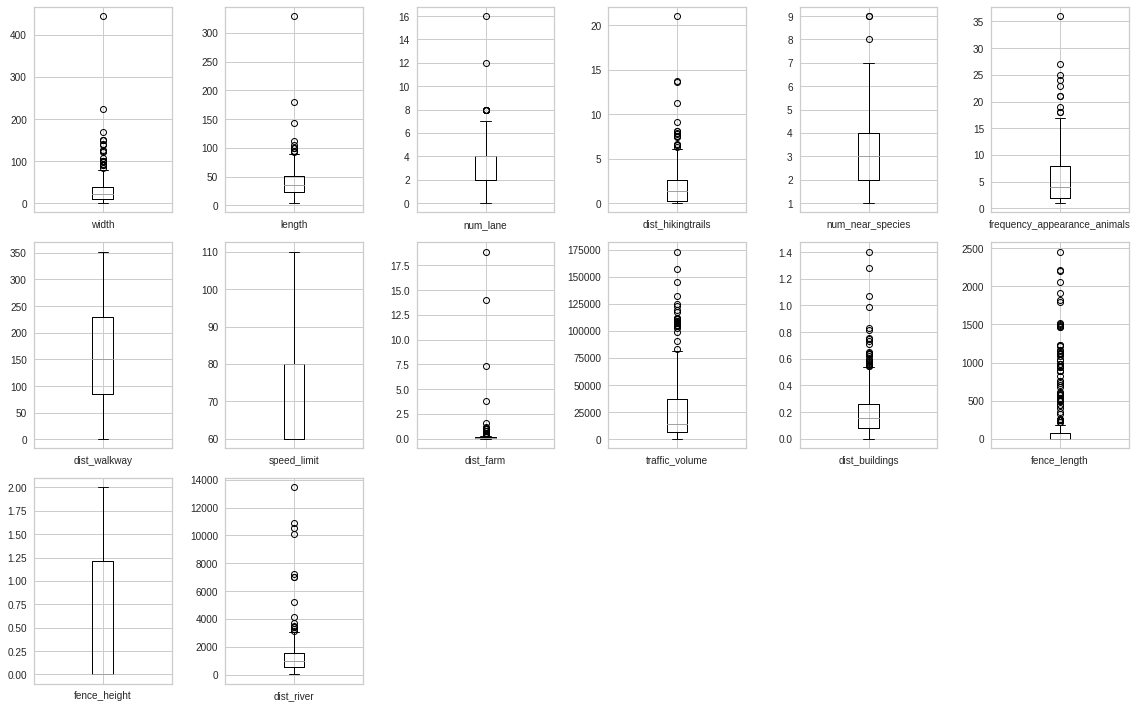

In [95]:
# overpass boxplot
plt.figure(figsize=(16, 10))

for i, col in enumerate(numerical_over):
  plt.subplot(3, 6, i+1)
  df_overpass.boxplot(col)

plt.tight_layout()
plt.show()

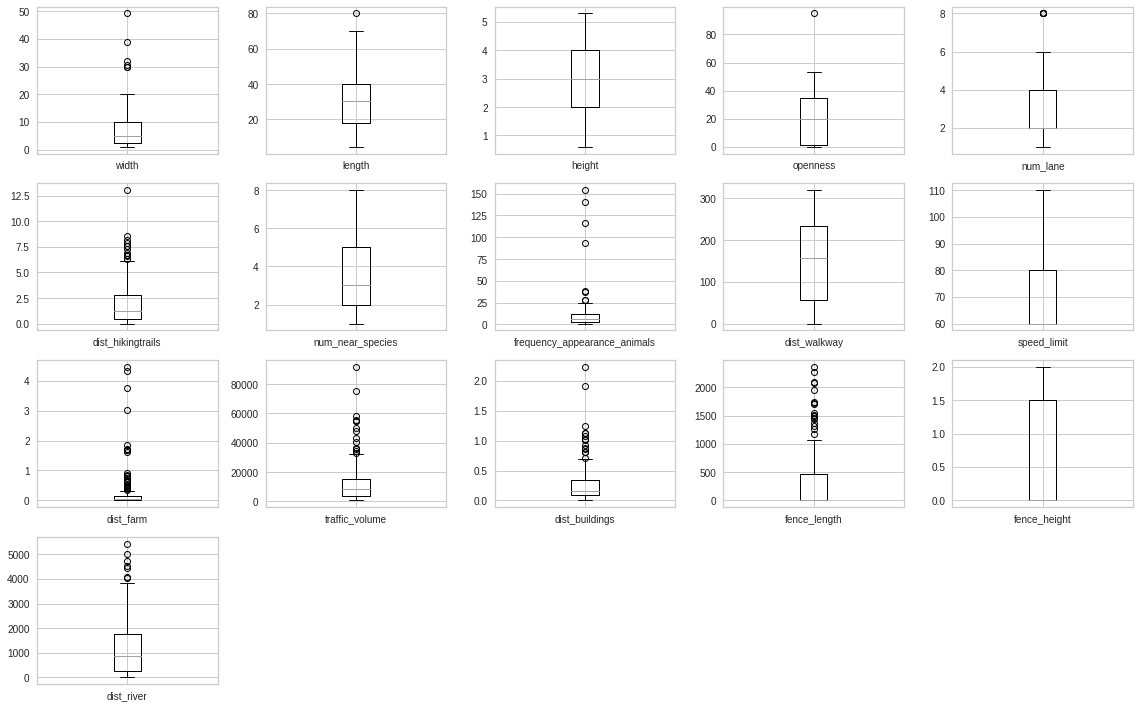

In [96]:
# tunnel boxplot
plt.figure(figsize=(16, 10))

for i, col in enumerate(numerical_tun):
  plt.subplot(4, 5, i+1)
  df_tunnel.boxplot(col)

plt.tight_layout()
plt.show()

### tukey fence method

In [97]:
# function : outlier → upper bound / lower bound
def change_outlier(df, col_list):
  for col_name in col_list:
      Q1 = df[col_name].quantile(q=0.25)
      Q3 = df[col_name].quantile(q=0.75)
      IQR = Q3-Q1

      print('[' + col_name + ']', end=' ')
      high_idx = df[df[col_name] > (Q3+1.5*IQR)].index
      df.loc[high_idx, col_name] = round(Q3+1.5*IQR, 1)
      print(str(len(high_idx)) +'개의 이상치를 상한값으로 변경', end=' / ')

      low_idx = df[df[col_name] < (Q1-1.5*IQR)].index
      df.loc[low_idx, col_name] = round(Q1-1.5*IQR, 1)
      print(str(len(low_idx)) +'개의 이상치를 하한값으로 변경')

  return df

In [98]:
df_overpass = change_outlier(df_overpass, numerical_over)
df_tunnel = change_outlier(df_tunnel, numerical_tun)

[width] 23개의 이상치를 상한값으로 변경 / 0개의 이상치를 하한값으로 변경
[length] 11개의 이상치를 상한값으로 변경 / 0개의 이상치를 하한값으로 변경
[num_lane] 8개의 이상치를 상한값으로 변경 / 0개의 이상치를 하한값으로 변경
[dist_hikingtrails] 16개의 이상치를 상한값으로 변경 / 0개의 이상치를 하한값으로 변경
[num_near_species] 3개의 이상치를 상한값으로 변경 / 0개의 이상치를 하한값으로 변경
[frequency_appearance_animals] 10개의 이상치를 상한값으로 변경 / 0개의 이상치를 하한값으로 변경
[dist_walkway] 0개의 이상치를 상한값으로 변경 / 0개의 이상치를 하한값으로 변경
[speed_limit] 0개의 이상치를 상한값으로 변경 / 0개의 이상치를 하한값으로 변경
[dist_farm] 26개의 이상치를 상한값으로 변경 / 0개의 이상치를 하한값으로 변경
[traffic_volume] 29개의 이상치를 상한값으로 변경 / 0개의 이상치를 하한값으로 변경
[dist_buildings] 23개의 이상치를 상한값으로 변경 / 0개의 이상치를 하한값으로 변경
[fence_length] 71개의 이상치를 상한값으로 변경 / 0개의 이상치를 하한값으로 변경
[fence_height] 0개의 이상치를 상한값으로 변경 / 0개의 이상치를 하한값으로 변경
[dist_river] 15개의 이상치를 상한값으로 변경 / 0개의 이상치를 하한값으로 변경
[width] 6개의 이상치를 상한값으로 변경 / 0개의 이상치를 하한값으로 변경
[length] 1개의 이상치를 상한값으로 변경 / 0개의 이상치를 하한값으로 변경
[height] 0개의 이상치를 상한값으로 변경 / 0개의 이상치를 하한값으로 변경
[openness] 1개의 이상치를 상한값으로 변경 / 0개의 이상치를 하한값으로 변경
[num_lane] 5개의 이상치를 상한값으로 변경 / 0개의 이상치를 하한값으로 변경
[dist

## Missing Values

In [99]:
# fence_length, fence_height, frequency_appearance_animals, num_near_species → 0 (not exist)
col = ['fence_length', 'fence_height', 'frequency_appearance_animals', 'num_near_species']

df_overpass[col].fillna(0, inplace=True)
df_tunnel[col].fillna(0, inplace=True)

### KNN

In [100]:
# function : knn algorithm
def KNNImputation(df, n_neighbors):
  imputer = KNNImputer(n_neighbors=n_neighbors)
  df_imputed = imputer.fit_transform(df)
  df = pd.DataFrame(df_imputed)
  return df

In [101]:
# width, length → knn
df_overpass[numerical_over] = KNNImputation(df_overpass[numerical_over], 3)
df_overpass.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 20 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   width                         300 non-null    float64
 1   length                        300 non-null    float64
 2   num_lane                      300 non-null    float64
 3   frequency_use_hikers          300 non-null    int64  
 4   efficiency                    300 non-null    int64  
 5   dist_hikingtrails             300 non-null    float64
 6   vegetation                    300 non-null    int64  
 7   soilslope                     300 non-null    int64  
 8   topography                    300 non-null    object 
 9   num_near_species              300 non-null    float64
 10  frequency_appearance_animals  300 non-null    float64
 11  dist_walkway                  300 non-null    float64
 12  speed_limit                   300 non-null    float64
 13  dist_

In [102]:
# width, length, height, openness → knn
df_tunnel[numerical_tun] = KNNImputation(df_tunnel[numerical_tun], 3)
df_tunnel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197 entries, 0 to 196
Data columns (total 22 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   width                         197 non-null    float64
 1   length                        197 non-null    float64
 2   height                        197 non-null    float64
 3   openness                      197 non-null    float64
 4   num_lane                      197 non-null    float64
 5   frequency_use_hikers          197 non-null    int64  
 6   efficiency                    197 non-null    int64  
 7   dist_hikingtrails             197 non-null    float64
 8   vegetation                    197 non-null    int64  
 9   soilslope                     197 non-null    int64  
 10  topography                    197 non-null    object 
 11  num_near_species              197 non-null    float64
 12  frequency_appearance_animals  197 non-null    float64
 13  dist_

## Pycaret : setup

In [103]:
# function : data preparation
def data_setup(data, target, ordinal_col, numeric_col, categorical_col):
  '''
  ordinal_features : Categorical features to be encoded ordinally
  fix_imbalance : When training dataset has unequal distribution of target class it can be balanced using this parameter (default = smote)
  normalize : it transforms the features by scaling them to a given range (default = zscore)
  remove_multicollinearity :  the variables with inter-correlations higher than the threshold defined under the multicollinearity_threshold param are dropped (0.5)
  feature_selection : a subset of features is selected based on a feature importance score determined by feature_selection_estimator (classic ; default = 0.8)
  # univariate: Uses sklearn’s SelectKBest.
  # classic : Uses sklearn’s SelectFromModel. # SelectFromModel : selecting features based on importance weights.
  # sequential : Uses sklearn’s SequtnailFeatureSelector.
  session_id : controls the randomness of experiment
  use_gpu : it will use GPU for training with algorithms that support it, and fall back to CPU if they are unavailable
  # preprocess : no transformations # preprocess = False
  '''
  clf = setup(data=data, target=target, train_size=0.8,
              ordinal_features=ordinal_col, numeric_features = numeric_col, categorical_features = categorical_col,
              fix_imbalance = True, normalize = True, remove_multicollinearity = True, multicollinearity_threshold = 0.5,
              feature_selection = True, session_id=123, use_gpu = True)

# Analytics model - Estimating Efficiency

In [104]:
# split : real data(not need to estimate) / predict data(need to estimate)

df_over_real = df_overpass[df_overpass['efficiency'] != 3]
df_over_predict = df_overpass[df_overpass['efficiency']==3]

# reset index
df_over_real.reset_index(drop = True,inplace= True)
df_over_predict.reset_index(drop = True,inplace= True)

# randomly add 1 value (This is because classification is impossible if only 3 values ​​exist)
df_over_predict.loc[1, 'efficiency']=0

df_tun_real = df_tunnel[df_tunnel['efficiency'] != 3]
df_tun_predict = df_tunnel[df_tunnel['efficiency'] == 3]

# reset index
df_tun_real.reset_index(drop = True,inplace= True)
df_tun_predict.reset_index(drop = True,inplace= True)

# randomly add 1 value (This is because classification is impossible if only 3 values ​​exist)
df_tun_predict.loc[1, 'efficiency']=0

In [105]:
# ordinal columns
ordinal_col = {'soilslope' : ['7', '6', '5', '4', '3', '2', '1'],
               'environmental_score' : ['5', '4', '3', '2', '1'],
               'frequency_use_hikers' : ['5', '4', '3', '2', '1', '0']}

## overpass

In [106]:
# data preparation
data_setup(df_over_real, 'efficiency', ordinal_col, numerical_over, categorical_col.remove('efficiency'))

,Description,Value
0,session_id,123
1,Target,efficiency
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(182, 20)"
5,Missing Values,False
6,Numeric Features,14
7,Categorical Features,5
8,Ordinal Features,True
9,High Cardinality Features,False


INFO:logs:create_model_container: 0
INFO:logs:master_model_container: 0
INFO:logs:display_container: 1
INFO:logs:Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
                                      display_types=True, features_todrop=[],
                                      id_columns=[],
                                      ml_usecase='classification',
                                      numerical_features=['width', 'length',
                                                          'num_lane',
                                                          'dist_hikingtrails',
                                                          'num_near_species',
                                                          'frequency_appearance_animals',
                                                          'dist_walkway',
                                                          'speed_limit',
                                    

In [107]:
# find best model (standard : accuracy)
compare_models(sort='Accuracy', errors='raise')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.5386,0.5321,0.6181,0.5994,0.6046,0.0461,0.0436,0.055
gbc,Gradient Boosting Classifier,0.5333,0.5416,0.6208,0.5763,0.5931,0.0435,0.0447,0.139
lr,Logistic Regression,0.5329,0.4969,0.5681,0.5851,0.5722,0.0575,0.0543,0.041
knn,K Neighbors Classifier,0.5324,0.5174,0.4847,0.6363,0.5369,0.0814,0.0900,0.198
rf,Random Forest Classifier,0.5310,0.5302,0.6542,0.5722,0.6035,0.0276,0.0271,1.085
ridge,Ridge Classifier,0.5129,0.0000,0.5444,0.5745,0.5556,0.0149,0.0121,0.037
lda,Linear Discriminant Analysis,0.5129,0.4985,0.5444,0.5745,0.5556,0.0149,0.0121,0.028
dt,Decision Tree Classifier,0.5124,0.4947,0.6181,0.5658,0.5894,-0.0088,-0.0086,0.030
et,Extra Trees Classifier,0.5105,0.5301,0.6069,0.5664,0.5766,-0.0030,-0.0007,1.055
ada,Ada Boost Classifier,0.4981,0.5279,0.6083,0.5491,0.5717,-0.0357,-0.0399,0.153


INFO:logs:create_model_container: 14
INFO:logs:master_model_container: 14
INFO:logs:display_container: 2
INFO:logs:LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=123, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
INFO:logs:compare_models() succesfully completed......................................


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=123, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [108]:
# creating model & predicting test set
best_over = create_model('dt')
predict_model(best_over)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.2667,0.2500,0.3333,0.3750,0.3529,-0.4865,-0.4910
1,0.4667,0.4444,0.5556,0.5556,0.5556,-0.1111,-0.1111
2,0.6000,0.5833,0.6667,0.6667,0.6667,0.1667,0.1667
3,0.6667,0.6607,0.7500,0.6667,0.7059,0.3243,0.3273
4,0.2667,0.2589,0.3750,0.3333,0.3529,-0.4865,-0.4910
5,0.3571,0.3333,0.5000,0.4444,0.4706,-0.3404,-0.3443
6,0.5714,0.5417,0.7500,0.6000,0.6667,0.0870,0.0913
7,0.5714,0.5417,0.7500,0.6000,0.6667,0.0870,0.0913
8,0.7143,0.7083,0.7500,0.7500,0.7500,0.4167,0.4167


INFO:logs:create_model_container: 15
INFO:logs:master_model_container: 15
INFO:logs:display_container: 3
INFO:logs:DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=123, splitter='best')
INFO:logs:create_model() succesfully completed......................................
INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
        

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Decision Tree Classifier,0.5405,0.5733,0.48,0.75,0.5854,0.1227,0.1386


,soilslope,topography_하천,length,frequency_appearance_animals,dist_buildings,dist_river,dist_walkway,fence_length,width,environmental_score,...,frequency_use_hikers,topography_기타,dist_farm,traffic_volume,speed_limit,vegetation_1,topography_산지,efficiency,Label,Score
0,3.0,1.0,1.874970,1.364096,-1.208099,-0.848881,0.053750,-0.597616,-0.336107,3.0,...,5.0,0.0,-1.170849,0.379614,0.400616,0.0,0.0,0,0,1.0
1,4.0,0.0,-0.582507,-0.346184,0.673828,-0.290218,1.376071,-0.597616,0.201743,0.0,...,3.0,0.0,0.709846,2.360012,0.400616,1.0,0.0,1,1,1.0
2,3.0,0.0,-0.141799,-0.944782,-0.466260,-0.904426,0.907575,-0.597616,-0.171493,1.0,...,5.0,0.0,1.782490,1.112835,-0.904763,1.0,0.0,1,0,1.0
3,5.0,0.0,-1.172301,2.903348,-0.333936,-0.676645,1.292512,-0.597616,2.768753,0.0,...,4.0,0.0,-0.468490,-0.450203,-0.904763,0.0,0.0,1,0,1.0
4,1.0,0.0,-0.435058,-0.602726,-0.364253,-0.664156,-0.271687,-0.597616,-0.825062,4.0,...,5.0,0.0,-1.154893,0.537021,-0.904763,0.0,0.0,1,1,1.0
5,1.0,1.0,0.041692,-0.773754,0.893990,-1.235532,-1.272232,-0.597616,0.011050,4.0,...,5.0,0.0,1.431673,-0.771448,0.400616,1.0,0.0,1,0,1.0
6,3.0,0.0,0.154736,-0.688240,-1.210965,-1.253648,-1.167063,1.765905,0.641801,3.0,...,5.0,0.0,-1.184551,-0.755287,1.705996,1.0,0.0,1,0,1.0
7,2.0,0.0,-0.611996,2.903348,0.646572,0.302658,0.315031,1.765905,-0.389892,3.0,...,5.0,0.0,-1.000286,-0.813320,-0.904763,0.0,0.0,1,0,1.0
8,3.0,1.0,0.719956,-0.431698,-0.803408,0.370123,-0.068669,-0.597616,-0.365444,4.0,...,4.0,0.0,-0.863598,-0.900413,0.400616,0.0,0.0,1,1,1.0
9,2.0,0.0,-0.189310,-0.517212,0.176189,-1.158197,0.284188,-0.597616,-0.693044,0.0,...,5.0,0.0,-0.515126,-0.832553,0.400616,1.0,0.0,0,0,1.0


In [109]:
# predicting dataset that needs estimation
predictions = predict_model(best_over, data=df_over_predict)

INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=123, splitter='best'), probability_threshold=None, encoded_labels=False, drift_report=False, raw_score=False, round=4, verbose=True, ml_usecase=MLUsecase.CLASSIFICATION, display=None, drift_kwargs=None)
INFO:logs:Checking exceptions
INFO:logs:Preloading libraries
INFO:logs:Preparing display monitor


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Decision Tree Classifier,0.0,0.2436,0,0,0,-0.0043,-0.047


In [110]:
# 3('판단불가') fill in the values ​​with the estimate
df_over_predict['efficiency'] = predictions['Label']
df_over_predict

,width,length,num_lane,frequency_use_hikers,efficiency,dist_hikingtrails,vegetation,soilslope,topography,num_near_species,frequency_appearance_animals,dist_walkway,speed_limit,dist_farm,traffic_volume,environmental_score,dist_buildings,fence_length,fence_height,dist_river
0,5.0,45.000000,4.0,1,1,3.157026,1,4,X,2.000000,2.000000,32.993820,80.0,0.223706,7493.875000,2,0.196597,0.0,0.0,134.468063
1,31.8,44.466667,4.0,0,1,4.207701,0,2,하천,1.666667,3.333333,243.678606,80.0,0.010158,83036.000000,3,0.052282,13.0,2.0,550.578792
2,26.0,19.600000,2.0,1,0,3.633748,0,6,하천,4.000000,7.000000,231.262942,60.0,0.189721,3789.800000,1,0.244889,0.0,0.0,1299.019181
3,83.5,60.000000,7.0,0,0,2.475586,0,6,X,1.666667,3.333333,208.008500,80.0,0.269432,83036.000000,5,0.123295,203.1,2.0,638.568718
4,30.8,23.800000,2.0,0,0,0.026200,1,5,X,3.000000,5.000000,268.671318,60.0,0.138246,13003.250000,2,0.250389,0.0,0.0,499.672342
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113,10.0,30.350000,2.0,0,0,6.200000,0,4,해안,3.000000,17.000000,195.644791,60.0,0.125751,9390.000000,1,0.186587,0.0,0.0,3074.100000
114,22.6,31.200000,2.0,5,0,0.000791,0,5,X,2.666667,5.333333,129.946664,60.0,0.015216,44834.000000,2,0.048330,0.0,0.0,700.836755
115,27.2,25.700000,4.0,5,1,0.364379,1,4,X,2.333333,4.666667,129.038518,80.0,0.051510,51655.166667,2,0.088941,0.0,0.0,1050.450948
116,7.2,23.800000,2.0,4,0,0.710065,0,3,X,1.333333,2.333333,128.838607,60.0,0.008750,45362.000000,5,0.054496,0.0,0.0,893.359640


In [112]:
# df_over_real, df_over_predict merge
df = pd.concat([df_over_real, df_over_predict], ignore_index=True)

# df to csv
# path = '/content/drive/MyDrive/maindata/'
# df.to_csv(path + 'overpass.csv', index=False, encoding='cp949')

df.to_sql('MainData_overpass' , index=False, con=db_connection, if_exists='replace')

## tunnel

In [113]:
# data preparation
data_setup(df_tun_real, 'efficiency', ordinal_col, numerical_tun, categorical_col)

,Description,Value
0,session_id,123
1,Target,efficiency
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(122, 22)"
5,Missing Values,False
6,Numeric Features,16
7,Categorical Features,5
8,Ordinal Features,True
9,High Cardinality Features,False


INFO:logs:create_model_container: 0
INFO:logs:master_model_container: 0
INFO:logs:display_container: 1
INFO:logs:Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=['frequency_use_hikers',
                                                            'soilslope',
                                                            'topography',
                                                            'vegetation',
                                                            'environmental_score'],
                                      display_types=True, features_todrop=[],
                                      id_columns=[],
                                      ml_usecase='classification',
                                      numerical_features=['width', 'length',
                                                          'height', 'openness',
                                                          'num_lane',
                        

In [114]:
# find best model (standard : accuracy)
compare_models(sort='Accuracy', errors='raise')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.7356,0.7632,0.7900,0.7762,0.7642,0.4410,0.4569,1.041
rf,Random Forest Classifier,0.7133,0.7733,0.7367,0.7602,0.7365,0.4103,0.4262,1.071
lightgbm,Light Gradient Boosting Machine,0.7022,0.7958,0.6800,0.8037,0.7020,0.4002,0.4431,0.048
lda,Linear Discriminant Analysis,0.6733,0.7370,0.6900,0.6818,0.6661,0.3295,0.3389,0.028
nb,Naive Bayes,0.6533,0.7125,0.6367,0.6681,0.6325,0.2857,0.2896,0.026
ridge,Ridge Classifier,0.6533,0.0000,0.6733,0.6785,0.6555,0.2911,0.3059,0.025
ada,Ada Boost Classifier,0.6500,0.7387,0.6400,0.7583,0.6432,0.2913,0.3339,0.147
gbc,Gradient Boosting Classifier,0.6489,0.6905,0.6733,0.6920,0.6632,0.2775,0.2981,0.118
lr,Logistic Regression,0.6311,0.7070,0.6533,0.6485,0.6313,0.2416,0.2498,0.042
svm,SVM - Linear Kernel,0.5778,0.0000,0.5867,0.6560,0.5512,0.1281,0.1347,0.024


INFO:logs:create_model_container: 14
INFO:logs:master_model_container: 14
INFO:logs:display_container: 2
INFO:logs:ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                     oob_score=False, random_state=123, verbose=0,
                     warm_start=False)
INFO:logs:compare_models() succesfully completed......................................


ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                     oob_score=False, random_state=123, verbose=0,
                     warm_start=False)

In [115]:
# creating model & predicting test set
best_tun = create_model('rf')
predict_model(best_tun)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8000,0.9167,0.6667,1.0000,0.8000,0.6154,0.6667
1,0.5000,0.6250,0.6667,0.5714,0.6154,-0.0870,-0.0891
2,0.7000,0.7917,0.8333,0.7143,0.7692,0.3478,0.3563
3,0.7000,0.6800,0.8000,0.6667,0.7273,0.4000,0.4082
4,0.7000,0.7200,0.6000,0.7500,0.6667,0.4000,0.4082
5,0.6000,0.6000,0.6000,0.6000,0.6000,0.2000,0.2000
6,0.8000,1.0000,0.6000,1.0000,0.7500,0.6000,0.6547
7,0.6667,0.7000,0.8000,0.6667,0.7273,0.3077,0.3162
8,0.7778,0.8000,0.8000,0.8000,0.8000,0.5500,0.5500


INFO:logs:create_model_container: 15
INFO:logs:master_model_container: 15
INFO:logs:display_container: 3
INFO:logs:RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=123, verbose=0,
                       warm_start=False)
INFO:logs:create_model() succesfully completed......................................
INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.68,0.7436,0.7692,0.6667,0.7143,0.3548,0.3595


,soilslope,length,frequency_appearance_animals,dist_buildings,dist_river,dist_walkway,width,environmental_score,dist_hikingtrails,frequency_use_hikers,topography_기타,height,traffic_volume,vegetation_1,topography_산지,openness,efficiency,Label,Score
0,2.0,-1.399180,-0.871909,-0.817715,-0.686664,1.568152,0.729555,0.0,-0.923259,4.0,0.0,-0.679010,-1.132164,1.0,0.0,-0.531289,0,0,0.68
1,1.0,-0.778539,0.237848,0.156722,0.302250,0.301937,0.054259,3.0,1.255528,4.0,0.0,0.150291,1.016778,1.0,0.0,0.539769,0,0,0.50
2,3.0,1.018674,-0.463051,0.768056,-0.695611,-1.322099,-1.129250,3.0,1.649674,3.0,0.0,-1.595607,-0.664577,0.0,0.0,1.945972,1,1,0.69
3,2.0,-0.181429,-0.404643,-0.308437,-0.430779,0.713328,-0.189404,4.0,-0.545282,4.0,1.0,1.023240,0.486164,1.0,0.0,2.445174,0,1,0.78
4,1.0,0.106831,1.464423,-1.084118,0.761430,0.692581,0.729555,3.0,1.825923,5.0,0.0,-0.286183,-0.759905,0.0,0.0,-0.988304,0,0,0.53
5,2.0,0.259786,-0.696685,0.062030,0.120011,-0.864249,1.189035,3.0,0.199641,4.0,0.0,-0.809953,0.033048,1.0,0.0,0.910069,0,1,0.65
6,1.0,0.259786,-0.696685,-0.565784,0.224679,-0.862301,1.189035,2.0,0.311498,5.0,0.0,-0.809953,0.033048,1.0,0.0,0.910069,1,1,0.73
7,3.0,0.833364,-1.163951,-0.516153,2.996291,1.077042,-1.094441,0.0,0.487708,5.0,1.0,-1.377370,-0.291045,0.0,0.0,1.095219,1,1,0.69
8,4.0,0.171543,0.413073,0.061983,-0.238474,0.419058,-0.711541,4.0,2.963653,5.0,0.0,0.761356,-0.099972,1.0,0.0,1.411615,0,1,0.65
9,4.0,-1.693323,-0.813501,1.308318,-0.442393,-1.160725,0.395388,4.0,-1.090938,0.0,0.0,-0.679010,-1.066522,0.0,0.0,-0.531289,1,1,0.63


In [116]:
# predicting dataset that needs estimation
predictions = predict_model(best_tun, data=df_tun_predict)

INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=123, verbose=0,
                       warm_start=False), probability_threshold=None, encoded_labels=False, drift_report=False, raw_score=False, round=4, verbose=True, ml_usecase=MLUsecase.CLASSIFICATION, display=None, drift_kwargs=None)
INFO:logs:Checking exceptions
INFO:logs:Preloading libraries
INFO:logs:Preparing display monitor


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.0,0.1622,0,0,0,-0.0037,-0.0362


In [117]:
# 3('판단불가') fill in the values ​​with the estimate
df_tun_predict['efficiency'] = predictions['Label']
df_tun_predict

,width,length,height,openness,num_lane,frequency_use_hikers,efficiency,dist_hikingtrails,vegetation,soilslope,...,frequency_appearance_animals,dist_walkway,speed_limit,dist_farm,traffic_volume,environmental_score,dist_buildings,fence_length,fence_height,dist_river
0,6.333333,18.666667,3.333333,1.466667,2.0,0,0,1.087578,1,3,...,5.000000,189.603501,60.0,0.303690,3573.857143,1,0.358139,0.0,0.000000,434.781679
1,7.000000,24.600000,3.666667,1.666667,2.0,1,1,3.694382,0,4,...,7.000000,231.385086,60.0,0.133653,3789.800000,1,0.172139,0.0,0.000000,1257.592562
2,9.466667,25.733333,1.733333,22.866667,4.0,0,1,0.188235,0,5,...,16.833333,4.186353,80.0,0.007450,6794.888889,3,0.196586,134.0,1.500000,30.852964
3,2.833333,38.066667,2.766667,38.733333,4.0,1,1,0.174459,1,3,...,1.000000,87.338109,80.0,0.092981,11056.478261,1,0.094104,1150.0,2.000000,2985.446339
4,6.833333,34.033333,2.500000,25.900000,4.0,0,1,0.384130,1,6,...,13.000000,41.065889,100.0,0.019857,4805.818182,2,0.079877,1150.0,1.555556,261.595037
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,6.566667,40.166667,3.633333,39.433333,2.0,4,1,2.891775,0,6,...,4.000000,81.388506,60.0,0.025394,26944.000000,1,0.017490,0.0,0.000000,4001.900000
71,9.466667,15.000000,2.200000,7.366667,2.0,0,1,1.644617,0,3,...,5.666667,50.922125,60.0,0.230351,1986.333333,1,0.653497,0.0,0.000000,440.918338
72,14.533333,22.000000,2.200000,7.366667,2.0,0,1,3.063221,0,6,...,2.000000,58.899113,60.0,0.300000,1720.000000,1,0.700000,0.0,0.000000,676.789715
73,6.333333,18.666667,3.333333,1.466667,2.0,0,1,2.259282,1,6,...,5.000000,49.401957,60.0,0.300000,3542.000000,1,0.340156,0.0,0.000000,113.026787


In [118]:
# df_tun_real, df_tun_predict  merge
df = pd.concat([df_tun_real, df_tun_predict], ignore_index=True)

# df to csv
# path = '/content/drive/MyDrive/maindata/'
# df.to_csv(path + 'tunnel.csv', index=False, encoding='cp949')

df.to_sql('MainData_tunnel' , index=False, con=db_connection, if_exists='replace')